In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

from datetime import timedelta
from astral import LocationInfo
from astral.sun import sun

In [2]:
# Load the CSV file into a DataFrame
#df = pd.read_csv('../data/August24_CB01/DataLog.txt', delimiter=',', names=['time', 'state', 'V'])
df = pd.read_csv('../data/August24_CB01/LabeledData.csv')
# Define the base directory where the images are stored
base_dir = '../data/August24_CB01/'

# Define your location
latitude = 34.0360  # Your latitude
longitude = -77.8938  # Your longitude

city = LocationInfo(latitude=latitude, longitude=longitude)


# Save the original Unix time in a new column
df['unix_time'] = df['time']

# Convert the 'time' column to datetime and localize it to the location's timezone
# Assuming the timezone is America/New_York (Eastern Time Zone), adjust as needed
df['time'] = pd.to_datetime(df['time'], unit='s').dt.tz_localize('UTC').dt.tz_convert(city.timezone)


# Display the first few rows of the DataFrame
df.head()

,time,state,V,label,unix_time
0,2024-08-05 16:48:07+01:00,NoFlood,8176,NoFlood,1722872887
1,2024-08-05 16:54:07+01:00,NoFlood,8176,NoFlood,1722873247
2,2024-08-05 17:00:07+01:00,NoFlood,8176,NoFlood,1722873607
3,2024-08-05 17:06:07+01:00,NoFlood,8176,NoFlood,1722873967
4,2024-08-05 17:12:07+01:00,NoFlood,8176,NoFlood,1722874327


In [3]:
#There is a strange time that i want to remove (2000)
# Find the minimum time
min_time = df['time'].min()

# Display the minimum time
print("Minimum time:", min_time)

# Remove the row with the minimum time
df = df[df['time'] != min_time]



Minimum time: 2000-01-01 00:00:07+00:00


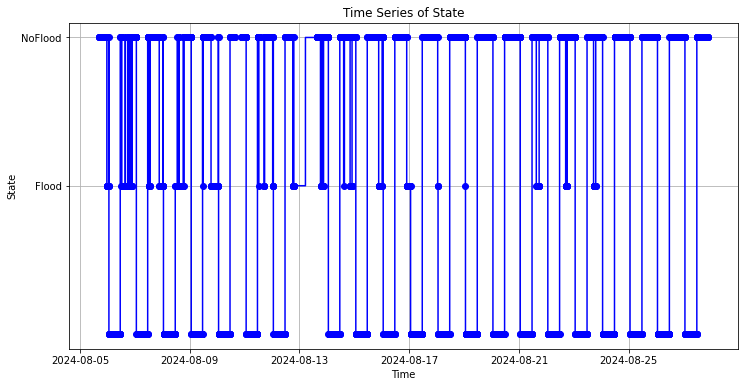

In [4]:
# Convert 'state' to a categorical numeric format
df['state_numeric'] = df['label'].astype('category').cat.codes

# Plot the time series of the state
plt.figure(figsize=(12, 6))
plt.step(df['time'], df['state_numeric'], where='mid', linestyle='-', marker='o', color='b')
plt.xlabel('Time')
plt.ylabel('State')
plt.title('Time Series of State')
plt.grid(True)

# Map the numeric values back to state names in the y-axis
state_labels = dict(enumerate(df['state'].astype('category').cat.categories))
plt.yticks(list(state_labels.keys()), list(state_labels.values()))

plt.show()

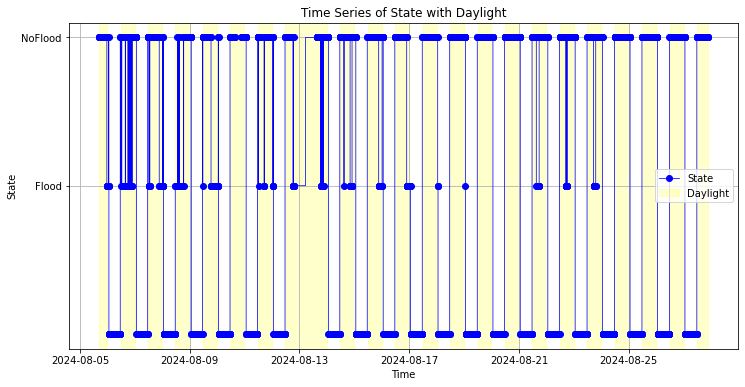

In [5]:


# Create a new column for daylight
df['daylight'] = 0

# Calculate sunrise for the current day and sunset for the next day
for index, row in df.iterrows():
    # Calculate sunrise for the current day
    s = sun(city.observer, date=row['time'].date(), tzinfo=row['time'].tzinfo)
    sunrise = s['sunrise']
    
    # Calculate sunset for the next day
    next_day = row['time'].date() + timedelta(days=1)
    s_next_day = sun(city.observer, date=next_day, tzinfo=row['time'].tzinfo)
    sunset = s_next_day['sunset']
    
    # Print the full datetime with timezone information
    #print(f"Sunrise: {sunrise} | Sunset: {sunset} | Row Time: {row['time']}")
    
    # Check if the time is between sunrise and sunset
    if sunrise <= row['time'] <= sunset:
        df.at[index, 'daylight'] = 1
        #print('Daylight period detected')


# Convert 'state' to a categorical numeric format
#df['state_numeric'] = df['state'].astype('category').cat.codes

plt.figure(figsize=(12, 6))
plt.step(df['time'], df['state_numeric'], where='mid', linestyle='-', marker='o', color='b', linewidth=0.75, label='State')

# Plot the daylight time series as a filled area with more transparency
plt.fill_between(df['time'], 0, 1, where=df['daylight'] == 1, color='yellow', alpha=0.2, transform=plt.gca().get_xaxis_transform(), label='Daylight')

# Labels and title
plt.xlabel('Time')
plt.ylabel('State')
plt.title('Time Series of State with Daylight')
plt.grid(True)

# Map the numeric values back to state names in the y-axis
state_labels = dict(enumerate(df['state'].astype('category').cat.categories))
plt.yticks(list(state_labels.keys()), list(state_labels.values()))

# Legend
plt.legend()

plt.show()

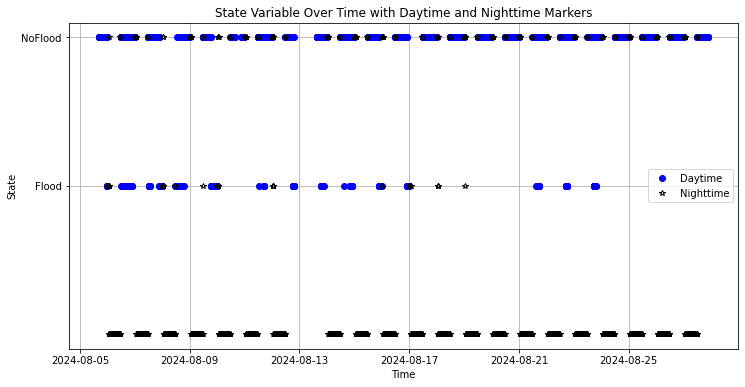

In [6]:

# Separate the DataFrame into daylight and nighttime DataFrames
daytime_df = df[df['daylight'] == 1]
nighttime_df = df[df['daylight'] == 0]

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the state variable for daytime (filled circles)
plt.plot(daytime_df['time'], daytime_df['state_numeric'], 'bo', label='Daytime', markerfacecolor='blue')

# Plot the state variable for nighttime (empty circles)
plt.plot(nighttime_df['time'], nighttime_df['state_numeric'], 'k*', label='Nighttime', markerfacecolor='none', markeredgecolor='black')

# Labels and title
plt.xlabel('Time')
plt.ylabel('State')
plt.title('State Variable Over Time with Daytime and Nighttime Markers')
plt.grid(True)

# Map the numeric values back to state names in the y-axis
state_labels = dict(enumerate(df['state'].astype('category').cat.categories))
plt.yticks(list(state_labels.keys()), list(state_labels.values()))

# Legend
plt.legend()

plt.show()

In [7]:
# ok, lets see if we can remove the dark nightime images...

# Set the threshold for detecting dark images
brightness_threshold = 10  # Adjust this value as needed

# Initialize a list to store whether each image is too dark
too_dark = []

# Loop through the DataFrame
for index, row in df.iterrows():
    
    # Construct the full file path
    im_path = str(row['unix_time']) + row['state'] + '.jpg'
    full_path = os.path.join(base_dir, im_path)
    
    try:
        # Load the image and convert to grayscale
        image = Image.open(full_path).convert('L')
        
        # Convert the image to a NumPy array
        image_array = np.array(image)
        
        # Calculate the average brightness
        avg_brightness = np.mean(image_array)
        
        # Determine if the image is too dark
        if avg_brightness > brightness_threshold:
            too_dark.append(False)  # Image is not too dark
        else:
            too_dark.append(True)   # Image is too dark
    except Exception as e:
        print(f"Warning: Could not process image at {full_path}. Error: {e}")
        too_dark.append(None)  # Mark as None if the image couldn't be processed

# Add the results to a new column in the DataFrame
df['too_dark'] = too_dark

# Display the first few rows of the updated DataFrame
#print(df.head())

In [8]:
df

,time,state,V,label,unix_time,state_numeric,daylight,too_dark
0,2024-08-05 16:48:07+01:00,NoFlood,8176,NoFlood,1722872887,1,1,False
1,2024-08-05 16:54:07+01:00,NoFlood,8176,NoFlood,1722873247,1,1,False
2,2024-08-05 17:00:07+01:00,NoFlood,8176,NoFlood,1722873607,1,1,False
3,2024-08-05 17:06:07+01:00,NoFlood,8176,NoFlood,1722873967,1,1,False
4,2024-08-05 17:12:07+01:00,NoFlood,8176,NoFlood,1722874327,1,1,False
...,...,...,...,...,...,...,...,...
4494,2024-08-27 20:42:07+01:00,NoFlood,8176,NoFlood,1724787727,1,1,False
4495,2024-08-27 20:48:07+01:00,NoFlood,8176,NoFlood,1724788087,1,1,False
4496,2024-08-27 20:54:07+01:00,NoFlood,8176,NoFlood,1724788447,1,1,False
4497,2024-08-27 21:00:07+01:00,NoFlood,8176,NoFlood,1724788807,1,1,False


In [9]:
too_dark_counts = df['too_dark'].value_counts()

# Display the counts
print(too_dark_counts)

False    2391
True     2099
Name: too_dark, dtype: int64


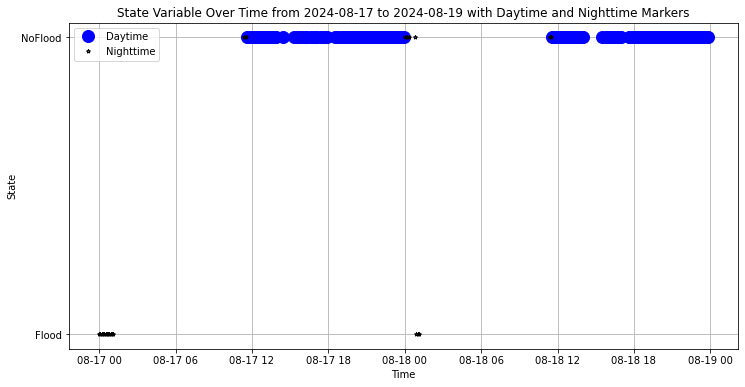

In [10]:

# Specify the date range (e.g., 2 days starting from '2024-08-17')
start_date = '2024-08-17'
end_date = '2024-08-19'

# Convert start_date and end_date to timezone-aware datetime objects
start_date = pd.to_datetime(start_date).tz_localize('Europe/London')
end_date = pd.to_datetime(end_date).tz_localize('Europe/London')


# Filter the DataFrame to include only the data within the specified date range
date_range_df = df[(df['time'] >= start_date) & (df['time'] <= end_date) & (df['too_dark'] == False)]

# Separate the date range DataFrame into daylight and nighttime DataFrames
daytime_df = date_range_df[date_range_df['daylight'] == 1]
nighttime_df = date_range_df[date_range_df['daylight'] == 0]


# Create the plot
plt.figure(figsize=(12, 6))

# Plot the state variable for daytime (filled circles)
plt.plot(daytime_df['time'], daytime_df['state_numeric'], 'bo', label='Daytime', markerfacecolor='blue', markersize=12)

# Plot the state variable for nighttime (empty circles)
plt.plot(nighttime_df['time'], nighttime_df['state_numeric'], 'k*', label='Nighttime', markerfacecolor='none', markeredgecolor='black', markersize=4)

# Labels and title
plt.xlabel('Time')
plt.ylabel('State')
plt.title(f'State Variable Over Time from {start_date.date()} to {end_date.date()} with Daytime and Nighttime Markers')
plt.grid(True)

# Map the numeric values back to state names in the y-axis
state_labels = dict(enumerate(df['state'].astype('category').cat.categories))
plt.yticks(list(state_labels.keys()), list(state_labels.values()))

# Legend
plt.legend()

plt.show()

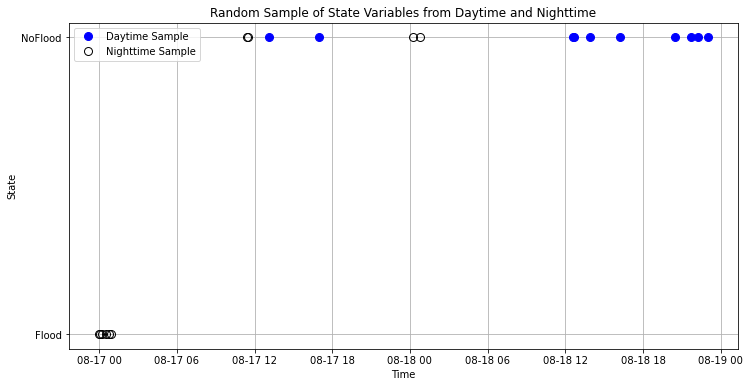

Daytime Sample File Paths:
2476      ../data/August24_CB01/1723985647Flood.jpg
2527      ../data/August24_CB01/1724013727Flood.jpg
2532      ../data/August24_CB01/1724015527Flood.jpg
2464      ../data/August24_CB01/1723981327Flood.jpg
2463      ../data/August24_CB01/1723980967Flood.jpg
2272      ../data/August24_CB01/1723896367Flood.jpg
2540      ../data/August24_CB01/1724018407Flood.jpg
2292    ../data/August24_CB01/1723910407NoFlood.jpg
2482      ../data/August24_CB01/1723993927Flood.jpg
2515      ../data/August24_CB01/1724009407Flood.jpg
Name: file_path, dtype: object

Nighttime Sample File Paths:
2348      ../data/August24_CB01/1723936327_Flood.jpg
2152      ../data/August24_CB01/1723852447_Flood.jpg
2143      ../data/August24_CB01/1723849207_Flood.jpg
2151    ../data/August24_CB01/1723852087_NoFlood.jpg
2350      ../data/August24_CB01/1723938487_Flood.jpg
2255      ../data/August24_CB01/1723890247_Flood.jpg
2144      ../data/August24_CB01/1723849567_Flood.jpg
2256      ../data/Aug

In [11]:

# Randomly sample 10 points from both daytime and nighttime data
daytime_sample = daytime_df.sample(10, random_state=42)
nighttime_sample = nighttime_df.sample(10, random_state=42)

# Generate file paths by concatenating 'unix_time' and 'state' columns
daytime_sample['file_path'] = '../data/August24_CB01/' + daytime_sample['unix_time'].astype(str) + daytime_sample['state'] + '.jpg'
nighttime_sample['file_path'] = '../data/August24_CB01/' + nighttime_sample['unix_time'].astype(str) + '_' + nighttime_sample['state'] + '.jpg'

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the sampled daytime points (filled circles)
plt.plot(daytime_sample['time'], daytime_sample['state_numeric'], 'bo', label='Daytime Sample', markerfacecolor='blue', markersize=8)

# Plot the sampled nighttime points (empty circles)
plt.plot(nighttime_sample['time'], nighttime_sample['state_numeric'], 'ko', label='Nighttime Sample', markerfacecolor='none', markeredgecolor='black', markersize=8)

# Labels and title
plt.xlabel('Time')
plt.ylabel('State')
plt.title(f'Random Sample of State Variables from Daytime and Nighttime')
plt.grid(True)

# Map the numeric values back to state names in the y-axis
state_labels = dict(enumerate(df['state'].astype('category').cat.categories))
plt.yticks(list(state_labels.keys()), list(state_labels.values()))

# Legend
plt.legend()

plt.show()

# Display the sampled file paths
print("Daytime Sample File Paths:")
print(daytime_sample['file_path'])

print("\nNighttime Sample File Paths:")
print(nighttime_sample['file_path'])

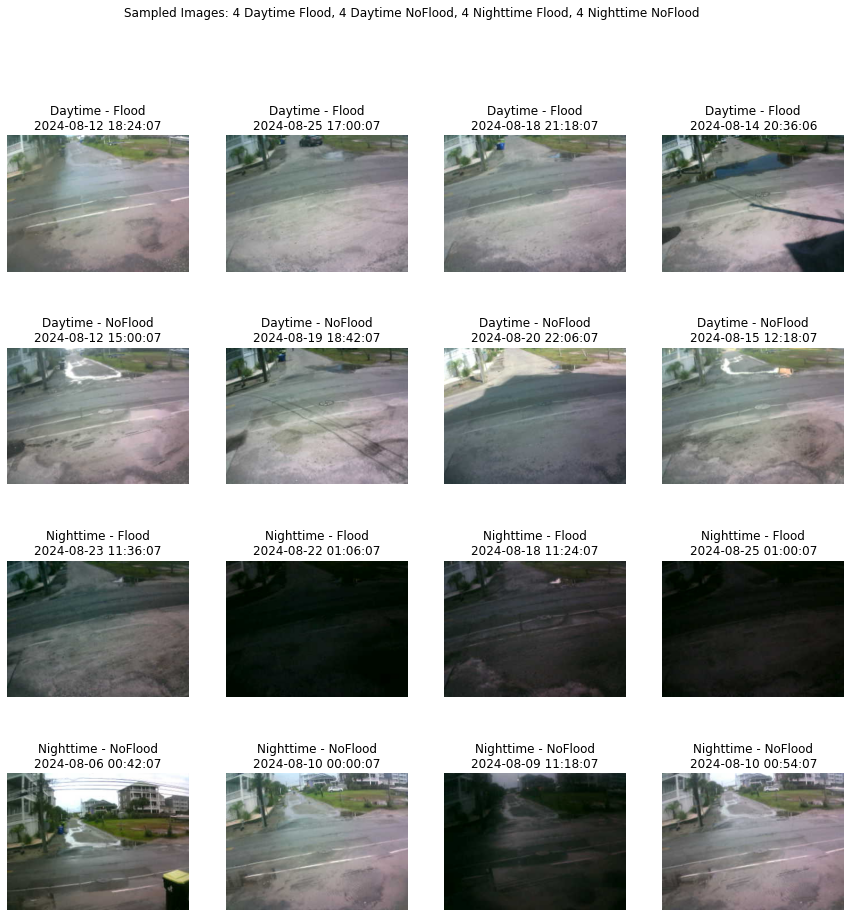

In [12]:

# Assume 'df' is your DataFrame with the 'daylight', 'time', 'state', 'unix_time', and 'file_path' columns.

# Define the base directory where the images are stored
#base_dir = '../data/August24_CB01/'

r_state = 25
#r_state = 13

# Filter the DataFrame into the four categories
daytime_flood_df = df[(df['daylight'] == 1) & (df['state'] == 'Flood')& (df['too_dark'] == False)]
daytime_no_flood_df = df[(df['daylight'] == 1) & (df['state'] == 'NoFlood')& (df['too_dark'] == False)]
nighttime_flood_df = df[(df['daylight'] == 0) & (df['state'] == 'Flood')& (df['too_dark'] == False)]
nighttime_no_flood_df = df[(df['daylight'] == 0) & (df['state'] == 'NoFlood')& (df['too_dark'] == False)]

# Randomly sample 4 points from each category
daytime_flood_sample = daytime_flood_df.sample(4, random_state=r_state)
daytime_no_flood_sample = daytime_no_flood_df.sample(4, random_state=r_state)
nighttime_flood_sample = nighttime_flood_df.sample(4, random_state=r_state)
nighttime_no_flood_sample = nighttime_no_flood_df.sample(4, random_state=r_state)

# Combine all samples into one DataFrame
all_samples = pd.concat([daytime_flood_sample, daytime_no_flood_sample, nighttime_flood_sample, nighttime_no_flood_sample])

# Generate file paths by concatenating 'unix_time' and 'state' columns
all_samples['file_path'] = all_samples['unix_time'].astype(str) + all_samples['state'] + '.jpg'

# Display images for all samples
plt.figure(figsize=(15, 15))
for i, (file_path, time) in enumerate(zip(all_samples['file_path'], all_samples['time'])):
    full_path = os.path.join(base_dir, file_path)
    img = Image.open(full_path)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    category = "Daytime" if all_samples.iloc[i]['daylight'] == 1 else "Nighttime"
    title = f"{category} - {all_samples.iloc[i]['state']}\n{time.strftime('%Y-%m-%d %H:%M:%S')}"
    plt.title(title)
    plt.axis('off')

plt.suptitle("Sampled Images: 4 Daytime Flood, 4 Daytime NoFlood, 4 Nighttime Flood, 4 Nighttime NoFlood")
plt.show()

In [13]:
df.to_csv('../data/deployment.csv', index=False) 

In [14]:
filepath = '../data/3786842.csv'


precip_df = pd.read_csv(filepath, header = 0, parse_dates = [5])
precip_df.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,...,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES,WT01,WT01_ATTRIBUTES,WT03,WT03_ATTRIBUTES,WT11,WT11_ATTRIBUTES
0,USC00319461,"WILMINGTON 7 SE, NC US",34.1425,-77.8788,9.1,2024-01-01,0.0,",,7,0700",0.0,",,7,0700",...,1.7,",,7",7.2,",,7,0700",NaN,NaN,NaN,NaN,NaN,NaN
1,USC00319461,"WILMINGTON 7 SE, NC US",34.1425,-77.8788,9.1,2024-01-02,0.0,",,7,0700",0.0,",,7,0700",...,2.2,",,7",2.2,",,7,0700",NaN,NaN,NaN,NaN,NaN,NaN
2,USC00319461,"WILMINGTON 7 SE, NC US",34.1425,-77.8788,9.1,2024-01-03,0.0,",,7,0700",0.0,",,7,0700",...,-0.6,",,7",-0.6,",,7,0700",NaN,NaN,NaN,NaN,NaN,NaN
3,USC00319461,"WILMINGTON 7 SE, NC US",34.1425,-77.8788,9.1,2024-01-04,10.7,",,7,0700",0.0,",,7,0700",...,-0.6,",,7",4.4,",,7,0700",NaN,NaN,NaN,NaN,NaN,NaN
4,USC00319461,"WILMINGTON 7 SE, NC US",34.1425,-77.8788,9.1,2024-01-05,0.0,",,7,0700",0.0,",,7,0700",...,-1.1,",,7",-0.6,",,7,0700",NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
deployment_df = df

# Convert the time columns to datetime format
deployment_df['time'] = deployment_df['time'].dt.tz_localize(None)
precip_df['timestamp'] = precip_df['DATE'].dt.tz_localize(None)

# Perform an asof merge to join on the closest matching time
merged_df = pd.merge_asof(deployment_df.sort_values('time'), precip_df.sort_values('timestamp'), left_on='time', right_on='timestamp')

# Display the first few rows of the merged DataFrame to confirm the result
merged_df.head()


,time,state,V,label,unix_time,state_numeric,daylight,too_dark,STATION,NAME,...,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES,WT01,WT01_ATTRIBUTES,WT03,WT03_ATTRIBUTES,WT11,WT11_ATTRIBUTES,timestamp
0,2024-08-05 16:48:07,NoFlood,8176,NoFlood,1722872887,1,1,False,USC00319461,"WILMINGTON 7 SE, NC US",...,",,H",26.1,",,H,0700",NaN,NaN,NaN,NaN,NaN,NaN,2024-08-05
1,2024-08-05 16:54:07,NoFlood,8176,NoFlood,1722873247,1,1,False,USC00319461,"WILMINGTON 7 SE, NC US",...,",,H",26.1,",,H,0700",NaN,NaN,NaN,NaN,NaN,NaN,2024-08-05
2,2024-08-05 17:00:07,NoFlood,8176,NoFlood,1722873607,1,1,False,USC00319461,"WILMINGTON 7 SE, NC US",...,",,H",26.1,",,H,0700",NaN,NaN,NaN,NaN,NaN,NaN,2024-08-05
3,2024-08-05 17:06:07,NoFlood,8176,NoFlood,1722873967,1,1,False,USC00319461,"WILMINGTON 7 SE, NC US",...,",,H",26.1,",,H,0700",NaN,NaN,NaN,NaN,NaN,NaN,2024-08-05
4,2024-08-05 17:12:07,NoFlood,8176,NoFlood,1722874327,1,1,False,USC00319461,"WILMINGTON 7 SE, NC US",...,",,H",26.1,",,H,0700",NaN,NaN,NaN,NaN,NaN,NaN,2024-08-05


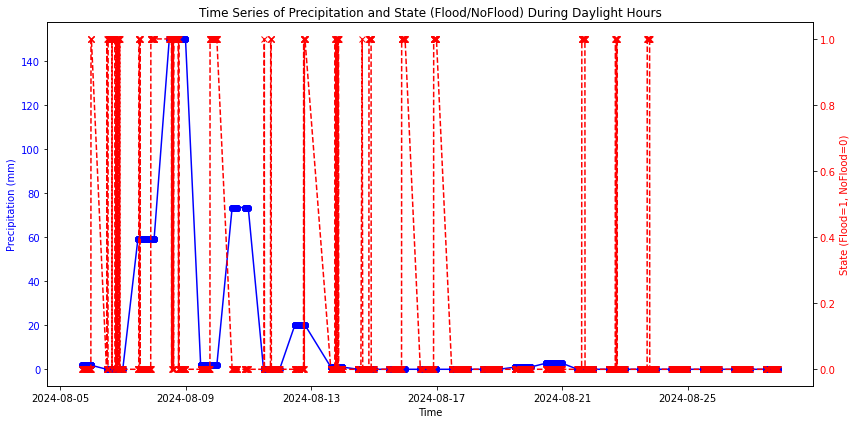

In [17]:

# Filter the DataFrame for daylight hours
daylight_df = merged_df[merged_df['daylight'] == 1]

# Create a figure and axis object
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the precipitation data on the primary y-axis
ax1.plot(daylight_df['time'], daylight_df['PRCP'], label='Precipitation (mm)', color='blue', linestyle='-', marker='o')
ax1.set_xlabel('Time')
ax1.set_ylabel('Precipitation (mm)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis to plot the state (flood/no flood)
ax2 = ax1.twinx()
ax2.plot(daylight_df['time'], daylight_df['label'].apply(lambda x: 1 if x == 'Flood' else 0), label='State (Flood/NoFlood)', color='red', linestyle='--', marker='x')
ax2.set_ylabel('State (Flood=1, NoFlood=0)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Set the title and show the plot
plt.title('Time Series of Precipitation and State (Flood/NoFlood) During Daylight Hours')
fig.tight_layout()
plt.show()

In [18]:
# Load the CSV file into a DataFrame
water_df = pd.read_csv('../data/CB_01_20240801_20240831.csv')

water_df['timestamp'] = pd.to_datetime(water_df['timestamp (UTC)'], format='%m/%d/%Y %H:%M')

# Display the first few rows of the DataFrame
water_df.head()

,timestamp (UTC),sensor elev. (ft NAVD88),road elev. (ft NAVD88),water level (ft NAVD88),water level (ft above or below road elev.),timestamp
0,08/01/2024 04:04,0.55,2.38,0.56,-1.82,2024-08-01 04:04:00
1,08/01/2024 04:10,0.55,2.38,0.56,-1.82,2024-08-01 04:10:00
2,08/01/2024 04:16,0.55,2.38,0.56,-1.82,2024-08-01 04:16:00
3,08/01/2024 04:22,0.55,2.38,0.56,-1.82,2024-08-01 04:22:00
4,08/01/2024 04:28,0.55,2.38,0.56,-1.82,2024-08-01 04:28:00


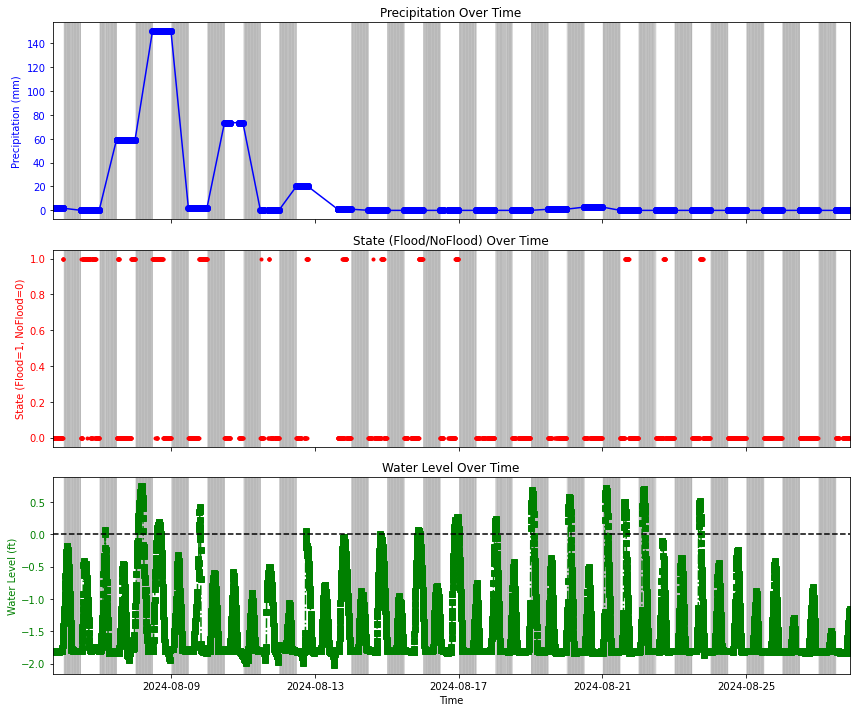

In [20]:

# Create a figure with three subplots stacked vertically
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot the precipitation data on the first axis
ax1.plot(daylight_df['time'], daylight_df['PRCP'], label='Precipitation (mm)', color='blue', linestyle='-', marker='o')
ax1.set_ylabel('Precipitation (mm)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Precipitation Over Time')

# Plot the state (flood/no flood) on the second axis
ax2.plot(daylight_df['time'], daylight_df['label'].apply(lambda x: 1 if x == 'Flood' else 0), 
         label='State (Flood/NoFlood)', color='red', linestyle='', marker='.')
ax2.set_ylabel('State (Flood=1, NoFlood=0)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_title('State (Flood/NoFlood) Over Time')


# Plot the water level (ft above or below road elev.) on the third axis
ax3.plot(water_df['timestamp'], water_df['water level (ft above or below road elev.)'], label='Water Level (ft above/below road)', color='green', linestyle='-.', marker='s')
ax3.axhline(0, color='black', linestyle='--')  # Add a horizontal dashed line at y=0.0
ax3.set_ylabel('Water Level (ft)', color='green')
ax3.tick_params(axis='y', labelcolor='green')
ax3.set_title('Water Level Over Time')


# Highlight nighttime periods with dark grey shading
for index, row in merged_df.iterrows():
    if row['daylight'] == 0:  # Assume 'daylight' is 1 for daytime and 0 for nighttime
        ax1.axvspan(row['time'], row['time'], color='gray', alpha=0.1)
        ax2.axvspan(row['time'], row['time'], color='gray', alpha=0.1)
        ax3.axvspan(row['time'], row['time'], color='gray', alpha=0.1)


# Set the x-axis limits to the range of the daylight_df time series on the bottom plot
ax3.set_xlim([daylight_df['time'].min(), daylight_df['time'].max()])

# Label the shared x-axis
ax3.set_xlabel('Time')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()




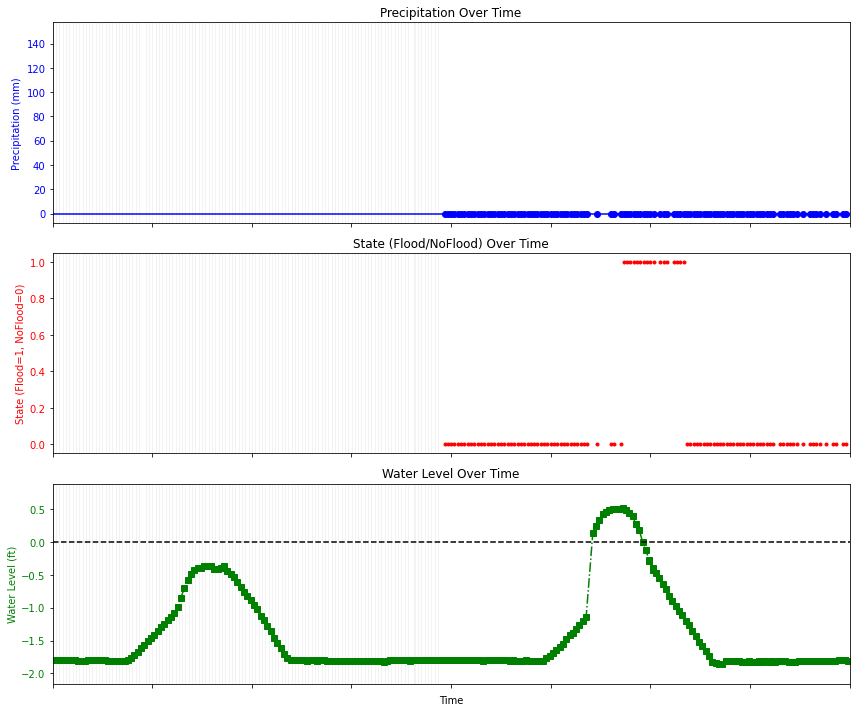

In [21]:

# Define the start and end time for zooming in
start_time = pd.to_datetime('2024-08-23')
end_time = pd.to_datetime('2024-08-24')



# Create a figure with three subplots stacked vertically
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot the precipitation data on the first axis
ax1.plot(daylight_df['time'], daylight_df['PRCP'], label='Precipitation (mm)', color='blue', linestyle='-', marker='o')
ax1.set_ylabel('Precipitation (mm)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Precipitation Over Time')

# Plot the state (flood/no flood) on the second axis
ax2.plot(daylight_df['time'], daylight_df['label'].apply(lambda x: 1 if x == 'Flood' else 0), 
         label='State (Flood/NoFlood)', color='red', linestyle='', marker='.')
ax2.set_ylabel('State (Flood=1, NoFlood=0)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_title('State (Flood/NoFlood) Over Time')


# Plot the water level (ft above or below road elev.) on the third axis
ax3.plot(water_df['timestamp'], water_df['water level (ft above or below road elev.)'], label='Water Level (ft above/below road)', color='green', linestyle='-.', marker='s')
ax3.axhline(0, color='black', linestyle='--')  # Add a horizontal dashed line at y=0.0
ax3.set_ylabel('Water Level (ft)', color='green')
ax3.tick_params(axis='y', labelcolor='green')
ax3.set_title('Water Level Over Time')


# Highlight nighttime periods with dark grey shading
for index, row in merged_df.iterrows():
    if row['daylight'] == 0:  # Assume 'daylight' is 1 for daytime and 0 for nighttime
        ax1.axvspan(row['time'], row['time'], color='gray', alpha=0.1)
        ax2.axvspan(row['time'], row['time'], color='gray', alpha=0.1)
        ax3.axvspan(row['time'], row['time'], color='gray', alpha=0.1)



# Set the x-axis limits to zoom in on the specific time range (2024-08-19 to 2024-08-22)
ax3.set_xlim([start_time, end_time])

# Highlight nighttime periods with dark grey shading using the full data
for index, row in daylight_df.iterrows():
    if row['daylight'] == 0:  # Assume 'daylight' is 1 for daytime and 0 for nighttime
        ax1.axvspan(row['time'], row['time'], color='gray', alpha=0.5)
        ax2.axvspan(row['time'], row['time'], color='gray', alpha=0.5)
        ax3.axvspan(row['time'], row['time'], color='gray', alpha=0.5)

# Label the shared x-axis (on the bottom plot)
ax3.set_xlabel('Time')

# Adjust the space between plots
plt.subplots_adjust(hspace=0)  # Removes space between the plots

# Remove x-axis labels from the top two plots to avoid redundancy
ax1.set_xticklabels([])
ax2.set_xticklabels([])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()




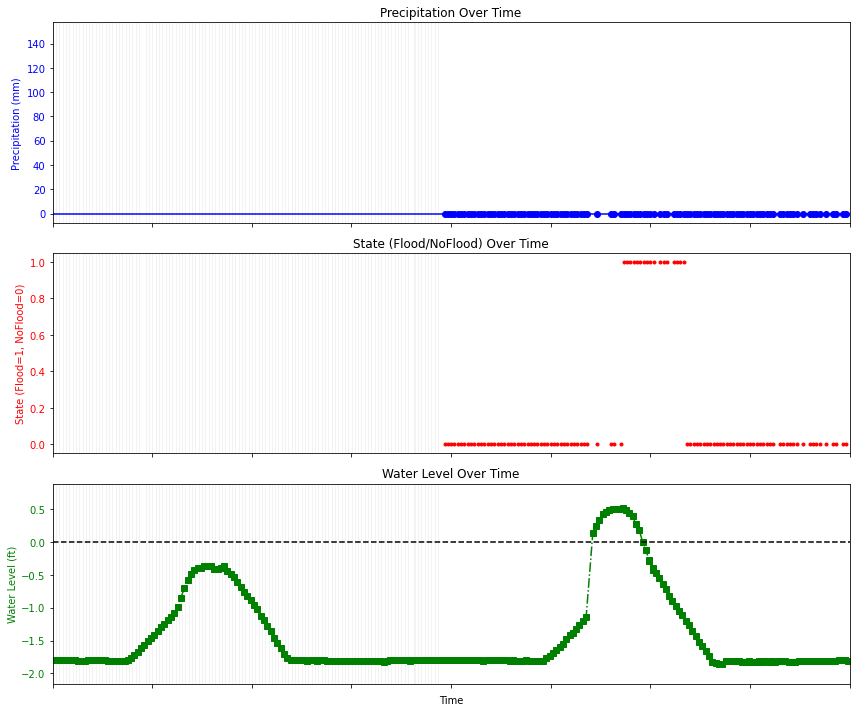

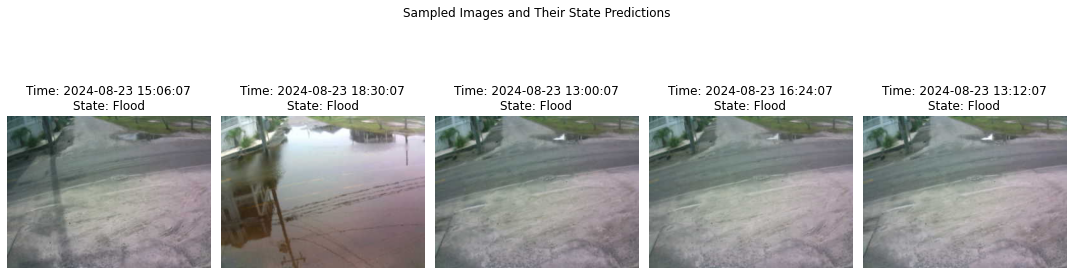

In [24]:
# Define the start and end time for zooming in
start_time = pd.to_datetime('2024-08-23')
end_time = pd.to_datetime('2024-08-24')



# Create a figure with three subplots stacked vertically
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot the precipitation data on the first axis
ax1.plot(daylight_df['time'], daylight_df['PRCP'], label='Precipitation (mm)', color='blue', linestyle='-', marker='o')
ax1.set_ylabel('Precipitation (mm)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Precipitation Over Time')

# Plot the state (flood/no flood) on the second axis
ax2.plot(daylight_df['time'], daylight_df['label'].apply(lambda x: 1 if x == 'Flood' else 0), 
         label='State (Flood/NoFlood)', color='red', linestyle='', marker='.')
ax2.set_ylabel('State (Flood=1, NoFlood=0)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_title('State (Flood/NoFlood) Over Time')


# Plot the water level (ft above or below road elev.) on the third axis
ax3.plot(water_df['timestamp'], water_df['water level (ft above or below road elev.)'], label='Water Level (ft above/below road)', color='green', linestyle='-.', marker='s')
ax3.axhline(0, color='black', linestyle='--')  # Add a horizontal dashed line at y=0.0
ax3.set_ylabel('Water Level (ft)', color='green')
ax3.tick_params(axis='y', labelcolor='green')
ax3.set_title('Water Level Over Time')


# Highlight nighttime periods with dark grey shading
for index, row in merged_df.iterrows():
    if row['daylight'] == 0:  # Assume 'daylight' is 1 for daytime and 0 for nighttime
        ax1.axvspan(row['time'], row['time'], color='gray', alpha=0.1)
        ax2.axvspan(row['time'], row['time'], color='gray', alpha=0.1)
        ax3.axvspan(row['time'], row['time'], color='gray', alpha=0.1)



# Set the x-axis limits to zoom in on the specific time range (2024-08-19 to 2024-08-22)
ax3.set_xlim([start_time, end_time])

# Highlight nighttime periods with dark grey shading using the full data
for index, row in daylight_df.iterrows():
    if row['daylight'] == 0:  # Assume 'daylight' is 1 for daytime and 0 for nighttime
        ax1.axvspan(row['time'], row['time'], color='gray', alpha=0.5)
        ax2.axvspan(row['time'], row['time'], color='gray', alpha=0.5)
        ax3.axvspan(row['time'], row['time'], color='gray', alpha=0.5)

# Label the shared x-axis (on the bottom plot)
ax3.set_xlabel('Time')

# Adjust the space between plots
plt.subplots_adjust(hspace=0)  # Removes space between the plots

# Remove x-axis labels from the top two plots to avoid redundancy
ax1.set_xticklabels([])
ax2.set_xticklabels([])

# Adjust layout to prevent overlap
plt.tight_layout()

# Filter the DataFrame for the given time period (start_time to end_time)
time_filtered_df = daylight_df[(daylight_df['time'] >= start_time) & (daylight_df['time'] <= end_time)]

# Randomly select 5 images
sampled_images = time_filtered_df.sample(n=5, random_state=13)

# Base directory where images are stored (replace with your actual path)
base_image_dir = '../data/August24_CB01/'  # Update this with the actual directory

# Plot the sampled images with their state predictions
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # Create a figure for 5 images

for i, row in enumerate(sampled_images.itertuples()):
    image_path = os.path.join(base_image_dir, f"{row.unix_time}{row.state}.jpg")  # Construct the image file path
    try:
        # Open and display the image
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Time: {row.time}\nState: {row.state}")
        axes[i].axis('off')  # Turn off the axis labels
    except FileNotFoundError:
        axes[i].text(0.5, 0.5, "Image not found", ha='center', va='center')
        axes[i].axis('off')

plt.suptitle('Sampled Images and Their State Predictions')
plt.tight_layout()
plt.show()


# Highlight the points corresponding to the selected images
highlight_times = sampled_images['time']

# Plot the highlights on the time series plots

ax2.scatter(highlight_times, time_filtered_df.loc[time_filtered_df['time'].isin(highlight_times), 
                                                  'state'].apply(lambda x: 1 if x == 'Flood' else 0), 
            color='yellow', edgecolor='black', zorder=5, s=100, label='Selected Image')


# # Add legends to indicate the highlighted points

ax2.legend(loc='upper right')

# Show the updated plot with highlighted points
plt.show()

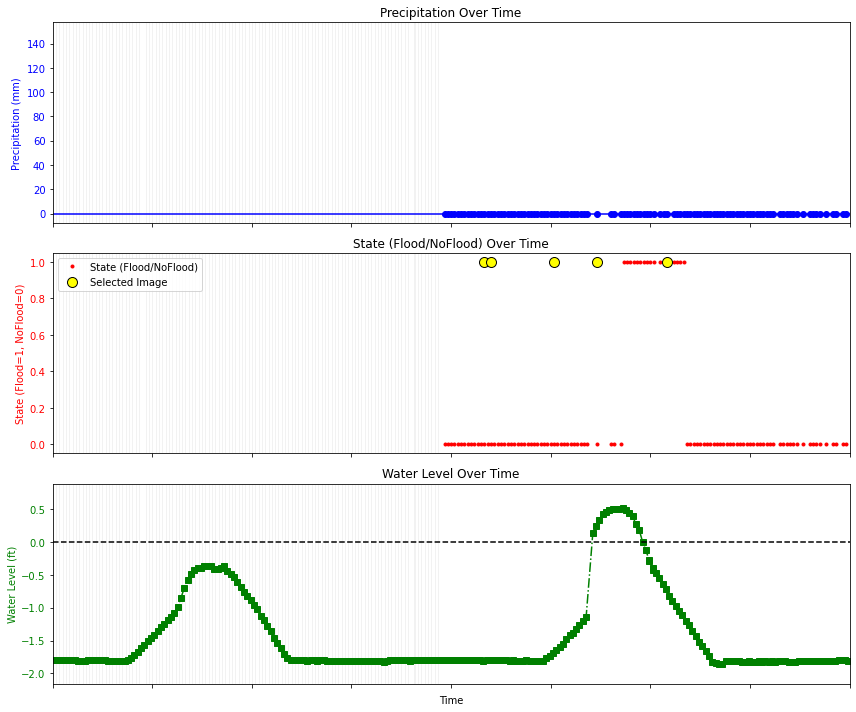

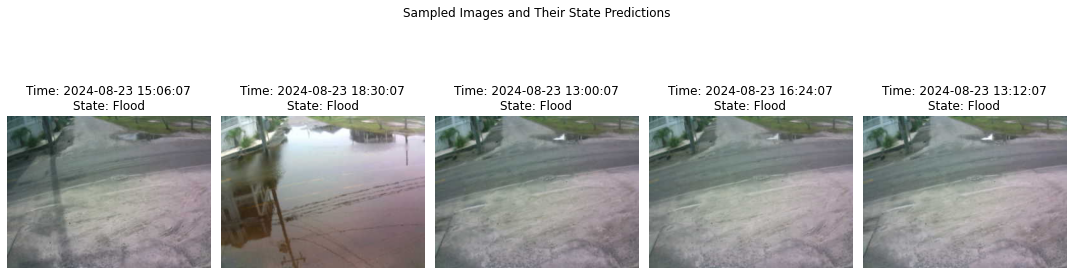

In [25]:
#define the start and end time for zooming in
start_time = pd.to_datetime('2024-08-23')
end_time = pd.to_datetime('2024-08-24')

# Filter the DataFrame for the given time period (start_time to end_time)
time_filtered_df = daylight_df[(daylight_df['time'] >= start_time) & (daylight_df['time'] <= end_time)]

# Randomly select 5 images from the filtered time range
sampled_images = time_filtered_df.sample(n=5, random_state=13)

# Get the timestamps of the selected images
highlight_times = sampled_images['time']

### Now we have the times, let's plot the time series with highlights ###

# Create a figure with three subplots stacked vertically
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot the precipitation data on the first axis
ax1.plot(daylight_df['time'], daylight_df['PRCP'], label='Precipitation (mm)', color='blue', linestyle='-', marker='o')
ax1.set_ylabel('Precipitation (mm)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Precipitation Over Time')

# Plot the state (flood/no flood) on the second axis
ax2.plot(daylight_df['time'], daylight_df['label'].apply(lambda x: 1 if x == 'Flood' else 0), 
         label='State (Flood/NoFlood)', color='red', linestyle='', marker='.')
ax2.set_ylabel('State (Flood=1, NoFlood=0)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_title('State (Flood/NoFlood) Over Time')

# Plot the water level (ft above or below road elev.) on the third axis
ax3.plot(water_df['timestamp'], water_df['water level (ft above or below road elev.)'], label='Water Level (ft above/below road)', color='green', linestyle='-.', marker='s')
ax3.axhline(0, color='black', linestyle='--')  # Add a horizontal dashed line at y=0.0
ax3.set_ylabel('Water Level (ft)', color='green')
ax3.tick_params(axis='y', labelcolor='green')
ax3.set_title('Water Level Over Time')

# Highlight nighttime periods with dark grey shading
for index, row in merged_df.iterrows():
    if row['daylight'] == 0:  # Assume 'daylight' is 1 for daytime and 0 for nighttime
        ax1.axvspan(row['time'], row['time'], color='gray', alpha=0.1)
        ax2.axvspan(row['time'], row['time'], color='gray', alpha=0.1)
        ax3.axvspan(row['time'], row['time'], color='gray', alpha=0.1)

# Set the x-axis limits to zoom in on the specific time range (start_time to end_time)
ax3.set_xlim([start_time, end_time])

# Highlight the points corresponding to the selected images on the second panel (state timeseries)
highlighted_states = daylight_df[daylight_df['time'].isin(highlight_times)]

# Plot the highlighted points on the second plot (state)
ax2.scatter(highlighted_states['time'], highlighted_states['state'].apply(lambda x: 1 if x == 'Flood' else 0), 
            color='yellow', edgecolor='black', zorder=5, s=100, label='Selected Image')

# Add legend to indicate the highlighted points
ax2.legend(loc='upper left')

# Label the shared x-axis (on the bottom plot)
ax3.set_xlabel('Time')

# Adjust the space between plots
plt.subplots_adjust(hspace=0)  # Removes space between the plots

# Remove x-axis labels from the top two plots to avoid redundancy
ax1.set_xticklabels([])
ax2.set_xticklabels([])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the updated plot with highlighted points
plt.show()

### Now plot the selected images ###

# Base directory where images are stored (replace with your actual path)
base_image_dir = '../data/August24_CB01/'  # Update this with the actual directory

# Plot the sampled images with their state predictions
fig, axes = plt.subplots(1, 5, figsize=(15, 5))  # Create a figure for 5 images

for i, row in enumerate(sampled_images.itertuples()):
    image_path = os.path.join(base_image_dir, f"{row.unix_time}{row.state}.jpg")  # Construct the image file path
    try:
        # Open and display the image
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Time: {row.time}\nState: {row.state}")
        axes[i].axis('off')  # Turn off the axis labels
    except FileNotFoundError:
        axes[i].text(0.5, 0.5, "Image not found", ha='center', va='center')
        axes[i].axis('off')

plt.suptitle('Sampled Images and Their State Predictions')
plt.tight_layout()
plt.show()

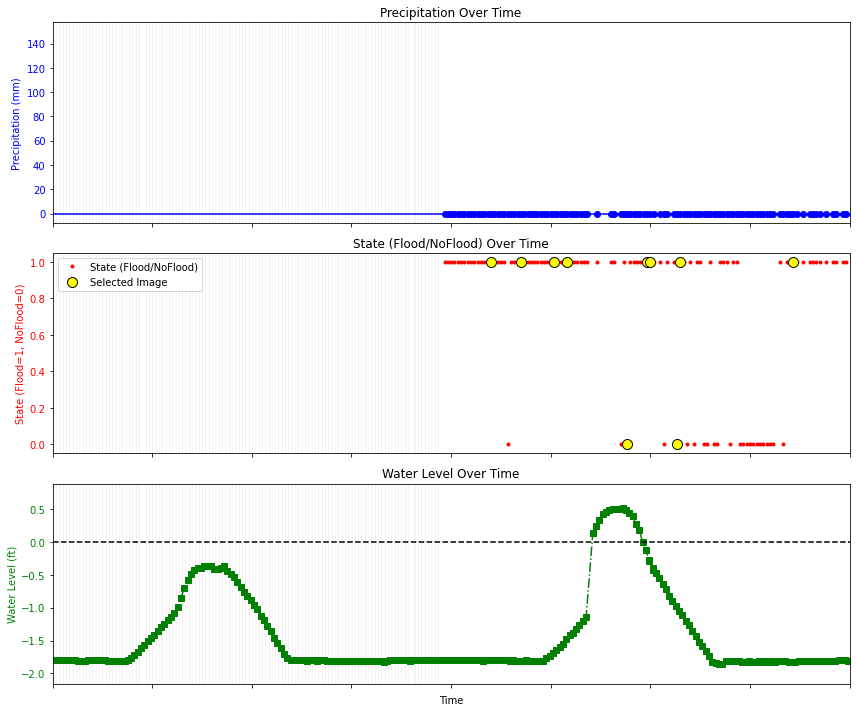

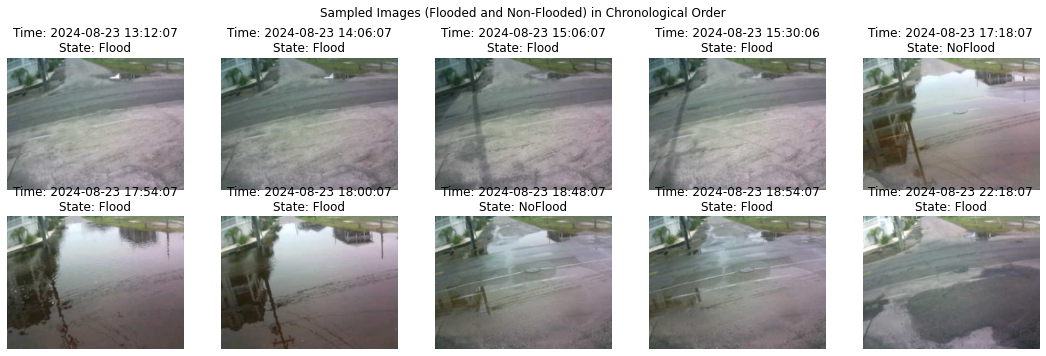

In [26]:

# Define the start and end time for zooming in
start_time = pd.to_datetime('2024-08-23')
end_time = pd.to_datetime('2024-08-24')

# Filter the DataFrame for the given time period (start_time to end_time)
time_filtered_df = daylight_df[(daylight_df['time'] >= start_time) & (daylight_df['time'] <= end_time)]

# Select 5 flooded images and 5 non-flooded images
flooded_images = time_filtered_df[time_filtered_df['label'] == 'Flood'].sample(n=5, random_state=13)
non_flooded_images = time_filtered_df[time_filtered_df['label'] == 'NoFlood'].sample(n=5, random_state=13)

# Combine the two sets of images and sort them in chronological order
sampled_images = pd.concat([flooded_images, non_flooded_images]).sort_values(by='time')

# Get the timestamps of the selected images
highlight_times = sampled_images['time']

### Now we have the times, let's plot the time series with highlights ###

# Create a figure with three subplots stacked vertically
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot the precipitation data on the first axis
ax1.plot(daylight_df['time'], daylight_df['PRCP'], label='Precipitation (mm)', color='blue', linestyle='-', marker='o')
ax1.set_ylabel('Precipitation (mm)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Precipitation Over Time')

# Plot the state (flood/no flood) on the second axis
ax2.plot(daylight_df['time'], daylight_df['state'].apply(lambda x: 1 if x == 'Flood' else 0), 
         label='State (Flood/NoFlood)', color='red', linestyle='', marker='.')
ax2.set_ylabel('State (Flood=1, NoFlood=0)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_title('State (Flood/NoFlood) Over Time')

# Plot the water level (ft above or below road elev.) on the third axis
ax3.plot(water_df['timestamp'], water_df['water level (ft above or below road elev.)'], label='Water Level (ft above/below road)', color='green', linestyle='-.', marker='s')
ax3.axhline(0, color='black', linestyle='--')  # Add a horizontal dashed line at y=0.0
ax3.set_ylabel('Water Level (ft)', color='green')
ax3.tick_params(axis='y', labelcolor='green')
ax3.set_title('Water Level Over Time')

# Highlight nighttime periods with dark grey shading
for index, row in merged_df.iterrows():
    if row['daylight'] == 0:  # Assume 'daylight' is 1 for daytime and 0 for nighttime
        ax1.axvspan(row['time'], row['time'], color='gray', alpha=0.1)
        ax2.axvspan(row['time'], row['time'], color='gray', alpha=0.1)
        ax3.axvspan(row['time'], row['time'], color='gray', alpha=0.1)

# Set the x-axis limits to zoom in on the specific time range (start_time to end_time)
ax3.set_xlim([start_time, end_time])

# Highlight the points corresponding to the selected images on the second panel (state timeseries)
highlighted_states = daylight_df[daylight_df['time'].isin(highlight_times)]

# Plot the highlighted points on the second plot (state)
ax2.scatter(highlighted_states['time'], highlighted_states['state'].apply(lambda x: 1 if x == 'Flood' else 0), 
            color='yellow', edgecolor='black', zorder=5, s=100, label='Selected Image')

# Add legend to indicate the highlighted points
ax2.legend(loc='upper left')

# Label the shared x-axis (on the bottom plot)
ax3.set_xlabel('Time')

# Adjust the space between plots
plt.subplots_adjust(hspace=0)  # Removes space between the plots

# Remove x-axis labels from the top two plots to avoid redundancy
ax1.set_xticklabels([])
ax2.set_xticklabels([])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the updated plot with highlighted points
plt.show()

### Now plot the selected images ###

# Base directory where images are stored (replace with your actual path)
base_image_dir = '../data/August24_CB01/'  # Update this with the actual directory

# Plot the sampled images with their state predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 5))  # Create a figure for 10 images (2 rows x 5 columns)

for i, row in enumerate(sampled_images.itertuples()):
    image_path = os.path.join(base_image_dir, f"{row.unix_time}{row.state}.jpg")  # Construct the image file path
    try:
        # Open and display the image
        img = Image.open(image_path)
        axes[i // 5, i % 5].imshow(img)  # Display images in 2 rows of 5
        axes[i // 5, i % 5].set_title(f"Time: {row.time}\nState: {row.state}")
        axes[i // 5, i % 5].axis('off')  # Turn off the axis labels
    except FileNotFoundError:
        axes[i // 5, i % 5].text(0.5, 0.5, "Image not found", ha='center', va='center')
        axes[i // 5, i % 5].axis('off')

plt.suptitle('Sampled Images (Flooded and Non-Flooded) in Chronological Order')
plt.tight_layout()
plt.show()